In [2]:
# Generic Comment
#* Important Comment
#! Warning
#? Suggestion
#TODO Todo list

import time
start_time = time.time()
import cyipopt
import math
from matplotlib import pyplot as plt
import numpy as np
from cyipopt import minimize_ipopt
from phe import paillier
from numba import *
%matplotlib widget

def compute_index(indices, dims):
    if len(indices) == 1:
        return indices[0]
    else:
        current_index = indices[0]
        remaining_dims_product = 1
        for dim in dims[1:]:
            remaining_dims_product *= dim
        return current_index * remaining_dims_product + compute_index(indices[1:], dims[1:])
        
end_time = time.time()
total_runtime = end_time - start_time
print("Total time required to import Modules = %f seconds " % total_runtime)

Total time required to import Modules = 1.688510 seconds 


In [49]:
class Ellipse:
    def __init__(self, A, B, C, F, u=0, v=0, angle=None):
        self.A, self.B, self.C, self.F = A, B, C, F
        self.u, self.v = u, v
        self.angle = angle if angle is not None else 0.5 * np.arctan2(B, A - C)  # Use arctan2 for correct quadrant
        self._calculate_transformed_coefficients()
        self._calculate_axes()
    def _calculate_transformed_coefficients(self):
        cos_angle, sin_angle = np.cos(self.angle), np.sin(self.angle)
        self.A_prime = self.A * cos_angle**2 + self.B * cos_angle * sin_angle + self.C * sin_angle**2
        self.C_prime = self.A * sin_angle**2 - self.B * cos_angle * sin_angle + self.C * cos_angle**2
    def _calculate_axes(self):
        self.a = np.sqrt(-self.F / self.A_prime)
        self.b = np.sqrt(-self.F / self.C_prime)
    def generate_points(self, n_points=100):
        t = np.linspace(0, 2 * np.pi, n_points)
        Ell = np.array([self.a * np.cos(t), self.b * np.sin(t)])
        R_rot = np.array([[np.cos(self.angle), -np.sin(self.angle)], 
                          [np.sin(self.angle), np.cos(self.angle)]])
        Ell_rot = np.dot(R_rot, Ell)
        return self.u + Ell_rot[0], self.v + Ell_rot[1]
    def plot(self, ax=None, n_points=100, **kwargs):
        if ax is None:
            ax = plt.gca()
        x, y = self.generate_points(n_points)
        return ax.plot(x, y, **kwargs)
    def is_inside(self, x, y):
        """Check if a point (x, y) is inside or on the ellipse."""
        return (self.A * (x - self.u)**2 + 
                self.B * (x - self.u) * (y - self.v) + 
                self.C * (y - self.v)**2 + self.F <= 0)
    def quantized_points(self, n_points=100, d=12):
        """
        Generate points on the ellipse, quantize them to 2^-d precision,
        and adjust any points outside the ellipse to be inside or on it.
        
        Parameters:
        n_points (int): Number of points to generate.
        d (int): The exponent for quantization precision (2^-d).
        
        Returns:
        tuple: Two arrays for x and y coordinates of the adjusted points.
        """
        x, y = self.generate_points(n_points)
        precision = 2 ** -d
        quantized = np.round(np.array([x, y]) / precision) * precision
        
        for i in range(len(quantized[0])):
            if not self.is_inside(quantized[0][i], quantized[1][i]):
                x, y = quantized[0][i], quantized[1][i]
                direction = np.array([x - self.u, y - self.v])
                direction = direction / np.linalg.norm(direction)
                while not self.is_inside(x, y):
                    x -= direction[0] * precision
                    y -= direction[1] * precision
                quantized[0][i], quantized[1][i] = x, y
        return quantized[0], quantized[1]

In [4]:
start_time = time.time()
public_key_CA, private_key_CA = paillier.generate_paillier_keypair(n_length=256)
public_key_T , private_key_T  = paillier.generate_paillier_keypair(n_length=256)

def encrypt(val,state,d1 = 12):
    match state:
        case 'CA': return public_key_CA.encrypt(val, precision = 2**(-d1))
        case 'T': return public_key_T.encrypt(val, precision = 2**(-d1))
        case _: raise ValueError("Invalid State Variable")
def decrypt(val,state):
    match state:
        case 'CA': return private_key_CA.decrypt(val)
        case 'T': return private_key_T.decrypt(val)
        case _: raise ValueError("Invalid State Variable")

end_time = time.time()
total_runtime = end_time - start_time
print("Total time required to initialize Encryption dependencies = %f seconds "% total_runtime)

Total time required to initialize Encryption dependencies = 0.011503 seconds 


In [5]:
start_time = time.time()
#########      Simulation time     #########################
hc = 1e-5  # hr Numerical Integration Step Size

######### MPC simulation constants #########################
PIcontrolStepSize = 10   # Integration Steps per PI Control Step

#########          P matrix        #########################
# V= xTP(x) "Energy of Sys"
a = 1060
b = 22
d = 0.52

end_time = time.time()
total_runtime = end_time - start_time
print("Total time required to initialize Control Paramters = %f seconds " % total_runtime)

Total time required to initialize Control Paramters = 0.000999 seconds 


In [6]:
start_time = time.time()
##################### Initializations ######################
e1 = []
e2 = []
encrypted_e1 = []
encrypted_e2 = []

################################ Parameters ######################

# Flowrate Terms
F = 5  # m^3/hr
V = 1  # m^3

# Thermochemical Properties
rhoe_L = 1e3  # kg/m3
Cp = 0.231  # kJ/kg-K
deltaH = -1.15e4  # kJ/kmol
E = 5e4  # kJ/kmol
R = 8.314  # kJ/kmolK
k0 = 8.46e6  # m3/kmol-h

# Thermal Properties
T0 = 300  # K

###################Simplifications################################
E_over_R = -E / R  # K
Coeff1 = F / V
Coeff2 = (deltaH * k0) / (rhoe_L * Cp)
Coeff3 = V * rhoe_L * Cp
######################## steady state values ########################
# Invariant Parameters
T0s = 300  # K

# State Variables
CAs = 1.9537  # kmol/m3
Ts = 401.87  # K

# Control Variables
Qs = 0.0  # kJ/hr
CA0s = 4  # kmol/m3

end_time = time.time()
total_runtime = end_time - start_time
print("Total time required to initialize Model Paramters = %f seconds " % total_runtime)

Total time required to initialize Model Paramters = 0.001001 seconds 


In [9]:
start_time = time.time()
@njit
def model_makestep(CA, T, CA0, Q, hc = hc, steps=1):
    for _ in range(steps):
        exp_E_over_R_Ts__CAs = np.exp(E_over_R / (Ts)) * (CAs) ** 2
        exp_E_over_R_T__CA   = np.exp(E_over_R / (T + Ts)) * (CA + CAs) ** 2
        fun_1 = (
            Coeff1 * (CA0 - CA)
            - k0 * exp_E_over_R_T__CA 
            + k0 * exp_E_over_R_Ts__CAs 
        )
        fun_2 = (
            Coeff1 * (T0 - T0s - T)
            - Coeff2 * exp_E_over_R_T__CA
            + Coeff2 * exp_E_over_R_Ts__CAs
            + (Q) / Coeff3
        )
        CA += hc * fun_1
        T  += hc * fun_2
    return CA, T
def solvePI(CA,T,CA_setpoint,T_setpoint,hc=hc,PIcontrolStepSize=10, Kc1 = 10, Kc2 = 10000, K_I1 = 20, K_I2 = 20, encrypted = True):
    if encrypted == True:
        CA_setpoint = encrypt(CA_setpoint,'CA')
        T_setpoint  = encrypt(T_setpoint,'T')
        CA          = encrypt(CA,'CA')
        T           = encrypt(T,'T')
    error1      = CA_setpoint-CA
    error2      = T_setpoint-T
    e1.append(error1)
    e2.append(error2)

    CA0 = Kc1*error1+K_I1*(PIcontrolStepSize*hc*sum(encrypted_e1))
    Q   = Kc2*error2+K_I2*(PIcontrolStepSize*hc*sum(encrypted_e2))
    if encrypted == True:
        CA0           = decrypt(CA0,'CA')
        Q             = decrypt(Q,'T')
    if (CA0   < CAO_L):
        CA0   = CAO_L
    elif(CA0  > CAO_U):
        CA0   = CAO_U
    if (Q     < Q_L):
        Q     = Q_L
    elif(Q    > Q_U):
        Q     = Q_U
    return [CA0,Q]
def calcVDot(CA,T,CA0,Q):
    LfV  = (2 * a * CA + 2 * b * T) * ( Coeff1*(0-CA)-k0*np.exp(E_over_R/(T+Ts))*(CA+CAs)**2+k0*np.exp(E_over_R/(Ts))*(CAs)**2 ) + \
          (2 * d * T + 2 * b * CA) * ( Coeff1*(T0-T0s-T)-Coeff2*np.exp(E_over_R/(T+Ts))*(CA+CAs)**2+Coeff2*np.exp(E_over_R/(Ts))*(CAs)**2+(0)/Coeff3 )
    Lg1V = (2 * a * CA + 2 * b * T) * Coeff1
    Lg2V = (2 * d * T + 2 * b * CA) / Coeff3
    return LfV + Lg1V * CA0 + Lg2V * Q  # (EMPC)Vdot = LfV(x)+LgV(x)*u
def plot_chevrons(x, y, ax=None,skipZero=True, plotColor = "green",spacing=1,head_size=0.2, arrow_style='->'):
    if ax is None:
        ax = plt.gca()
    ax.plot(x,y,'r-')
    if skipZero == True:
        startPoint = spacing-1
    else:
        startPoint = 0
    for i in range(startPoint,len(x)-1, spacing):
        mid_x, mid_y = (x[i] + x[i+1]) / 2, (y[i] + y[i+1]) / 2
        dx, dy = x[i+1] - x[i], y[i+1] - y[i]
        
        # Calculate angle for arrow rotation
        angle = np.degrees(np.arctan2(dy, dx))
        
        # Place an arrow annotation at the midpoint
        ax.annotate('', xy=(x[i+1], y[i+1]), xytext=(x[i], y[i]), 
                    arrowprops=dict(arrowstyle=arrow_style, 
                                    connectionstyle=f"arc3,rad=0.",  # No bending
                                    shrinkA=0, shrinkB=0,  # No shrinkage at either end
                                    mutation_scale=head_size, 
                                    fc=plotColor, ec=plotColor),
                    bbox=dict(boxstyle="square", fc="w", ec="none"),  # White background for better visibility
                    zorder=3)  # Ensure arrowheads are on top
CAO_L = -3.5
CAO_U = 3.5
Q_L = -5e5
Q_U = 5e5
end_time = time.time()
total_runtime = end_time - start_time
print("Total time required to initialize functions = %f seconds " % total_runtime)

Total time required to initialize functions = 0.002002 seconds 


In [ ]:
import random
A, B, C, F = 1060, 44, 0.52, -320
stabilityRegion = Ellipse(A, B, C, F)
unsolved = True
while unsolved:
    Kc1 = 10 ** random.uniform(math.log10(1e-5), math.log10(1e5))
    Kc2 = 10 ** random.uniform(math.log10(1e-5), math.log10(1e5))
    K_I1 = 10 ** random.uniform(math.log10(1e-5), math.log10(1e5))
    K_I2 = 10 ** random.uniform(math.log10(1e-5), math.log10(1e5))
    invalid = True
    while invalid:
        stabilityRegion.__init__(A, B, C, F)
        e1 = []
        e2 = []
        sampleSize = 101
        iterations = 1
        # Generate, quantize, and adjust points
        CA_adjusted, T_adjusted = stabilityRegion.quantized_points(n_points=sampleSize)
        pointsGenerated = len(CA_adjusted)
        plotColor = 'green'
        invalid = False
        for i in range(pointsGenerated):
            CA_record = (iterations+1)*[CA_adjusted[i]]
            T_record = (iterations+1)*[T_adjusted[i]]
            for j in range(iterations):
                CA0, Q = solvePI(CA_record[j],T_record[j],0,0,hc=1e-5,PIcontrolStepSize=10,Kc1 = 10, Kc2 = 10000, K_I1 = 2, K_I2 = 2,encrypted=True)
                if calcVDot(CA_record[j],T_record[j],CA0,Q)>0:
                    plotColor = 'red'
                    invalid = True
                CA_record[j+1], T_record[j+1] = model_makestep(CA_record[j],T_record[j],CA0,Q, hc=hc,steps = PIcontrolStepSize)
        F+=1
        if F==0:
            break
    if (1-F)>=320:
        unsolved = False
        plt.close('all')
        plt.figure()
        stabilityRegion.plot()
        plot_chevrons(CA_record,T_record,spacing = max(1,iterations//2), head_size = 10)
plt.savefig('fastPI.png', format='png', bbox_inches="tight")
plt.show()
print(f"V of {1-F} found for Kc1={Kc1}, Kc2={Kc2}, K_I1={K_I1}, K_I2={K_I2}")

C:\Users\arthu\AppData\Local\Temp\ipykernel_2036\1079605888.py:13: RuntimeWarning: invalid value encountered in sqrt
  self.a = np.sqrt(-self.F / self.A_prime)
C:\Users\arthu\AppData\Local\Temp\ipykernel_2036\1079605888.py:14: RuntimeWarning: invalid value encountered in sqrt
  self.b = np.sqrt(-self.F / self.C_prime)


In [120]:
import random
import math

# Generate a random number in the range from 1e-5 to 1e5
random_number = 10 ** random.uniform(math.log10(1e-5), math.log10(1e5))
random_number2 = 10 ** random.uniform(math.log10(1e-5), math.log10(1e5))
print(random_number)
print(random_number2)

2.634168384990136
1340.7839479425636


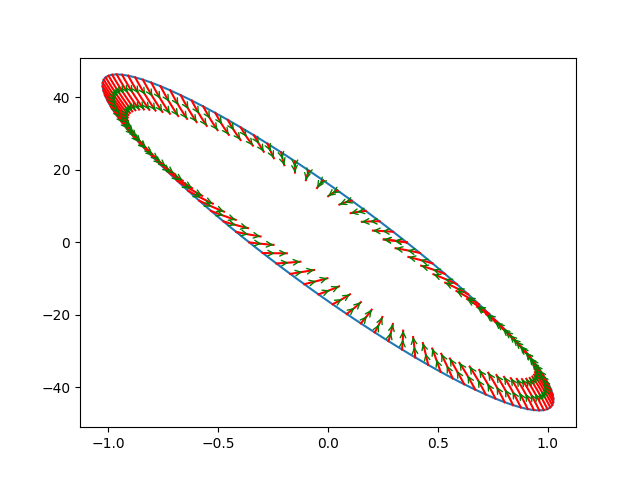

The max value of V is 135


In [214]:
A, B, C, F = 1060, 44, 0.52, -320
stabilityRegion = Ellipse(A, B, C, F)
invalid = True
while invalid:
    e1 = []
    e2 = []
    plt.close('all')
    plt.figure()
    stabilityRegion.plot()
    sampleSize = 101
    iterations = 10
    # Generate, quantize, and adjust points
    CA_adjusted, T_adjusted = stabilityRegion.generate_points(n_points=sampleSize)
    pointsGenerated = len(CA_adjusted)
    plotColor = 'green'
    invalid = False
    for i in range(pointsGenerated):
        CA_record = (iterations+1)*[CA_adjusted[i]]
        T_record = (iterations+1)*[T_adjusted[i]]
        for j in range(iterations):
            CA0, Q = solvePI(CA_record[j],T_record[j],0,0,hc=1e-4,PIcontrolStepSize=5,Kc1 = 10, Kc2 = 10000, K_I1 = 20, K_I2 = 20,encrypted=False)
            if calcVDot(CA_record[j],T_record[j],CA0,Q)>0:
                plotColor = 'red'
                invalid = True
            CA_record[j+1], T_record[j+1] = model_makestep(CA_record[j],T_record[j],CA0,Q,hc=hc,steps = PIcontrolStepSize)
        plot_chevrons(CA_record,T_record,spacing = max(1,iterations//2), head_size = 10)
    F+=1
    if F==0:
        break
    stabilityRegion.__init__(A, B, C, F)
plt.savefig('slowPI.png', format='png', bbox_inches="tight")
plt.show()
print(f"The max value of V is {-F}")

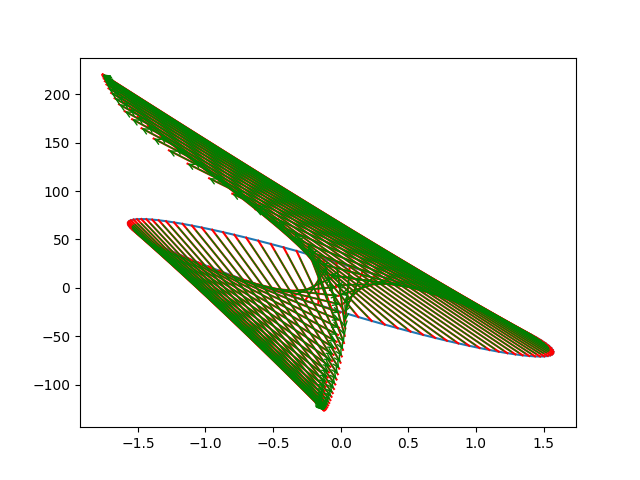

The max value of V is 319


In [218]:
Kc1 = 2
Kc2 = 12000

A, B, C, F = 1060, 44, 0.52, -320
stabilityRegion = Ellipse(A, B, C, F)
invalid = True
while invalid:
    e1 = []
    e2 = []
    plt.close('all')
    plt.figure()
    stabilityRegion.plot()
    sampleSize = 101
    iterations = 1
    # Generate, quantize, and adjust points
    CA_adjusted, T_adjusted = stabilityRegion.quantized_points(n_points=sampleSize)
    pointsGenerated = len(CA_adjusted)
    plotColor = 'green'
    invalid = False
    for i in range(pointsGenerated):
        CA_record = (iterations+1)*[CA_adjusted[i]]
        T_record = (iterations+1)*[T_adjusted[i]]
        for j in range(iterations):
            CA0, Q = -Kc1*CA_record[j], -Kc2*T_record[j]
            if calcVDot(CA_record[j],T_record[j],CA0,Q)>0:
                plotColor = 'red'
                invalid = True
            CA_record[j+1], T_record[j+1] = model_makestep(CA_record[j],T_record[j],CA0,Q,hc=1e-4,steps = 500)
        plot_chevrons(CA_record,T_record,spacing = max(1,iterations//2), head_size = 10)
    F+=1
    if F==0:
        break
    stabilityRegion.__init__(A, B, C, F)
plt.savefig('slowP.png', format='png', bbox_inches="tight")
plt.show()
print(f"The max value of V is {-F}")


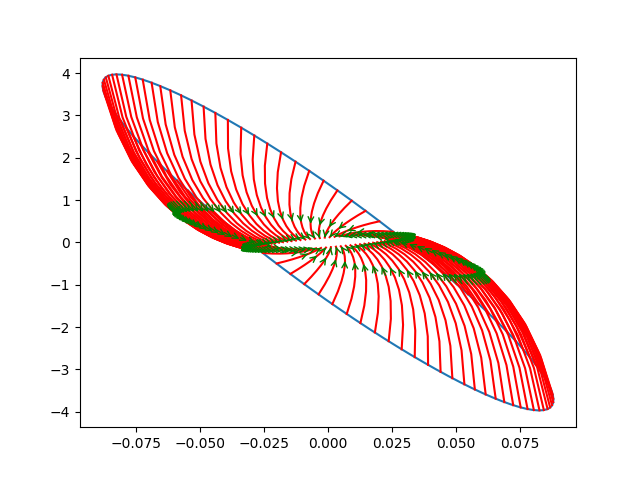

The max value of V is 0


In [221]:
Kc1 = 2
Kc2 = 12000

A, B, C, F = 1060, 44, 0.52, -320
stabilityRegion = Ellipse(A, B, C, F)
invalid = True
while invalid:
    e1 = []
    e2 = []
    plt.close('all')
    plt.figure()
    stabilityRegion.plot()
    sampleSize = 101
    iterations = 10
    # Generate, quantize, and adjust points
    CA_adjusted, T_adjusted = stabilityRegion.quantized_points(n_points=sampleSize)
    pointsGenerated = len(CA_adjusted)
    plotColor = 'green'
    invalid = False
    for i in range(pointsGenerated):
        CA_record = (iterations+1)*[CA_adjusted[i]]
        T_record = (iterations+1)*[T_adjusted[i]]
        for j in range(iterations):
            CA0, Q = -Kc1*CA_record[j], -Kc2*T_record[j]
            if calcVDot(CA_record[j],T_record[j],CA0,Q)>0:
                plotColor = 'red'
                invalid = True
            CA_record[j+1], T_record[j+1] = model_makestep(CA_record[j],T_record[j],CA0,Q,hc=1e-5,steps = 500)
        plot_chevrons(CA_record,T_record,spacing = max(1,iterations//2), head_size = 10)
    F+=1
    if F==0:
        break
    stabilityRegion.__init__(A, B, C, F)
plt.savefig('fastP_short.png', format='png', bbox_inches="tight")
plt.show()
print(f"The max value of V is {-F}")

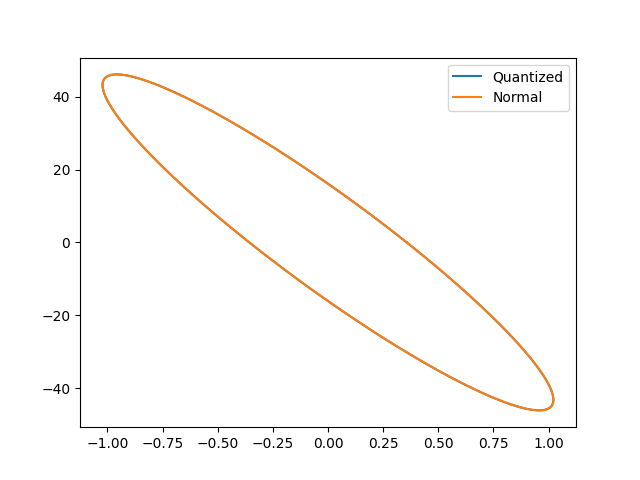

In [21]:
A, B, C, F = 1060, 44, 0.52, -135
stabilityRegion = Ellipse(A, B, C, F)
plt.close('all')
CA_adjusted, T_adjusted = stabilityRegion.quantized_points()
plt.plot(CA_adjusted,T_adjusted)
stabilityRegion.plot()
plt.legend(["Quantized","Normal"])
plt.show()